In [1]:
import os
os.chdir("../..")
import torch
import numpy as np
from data.gp_dataloader import GPDataGenerator
from models.anp import ANPModel, train_1d
from utils import Attention, plot_np_results

# Set the random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

Using device: cuda


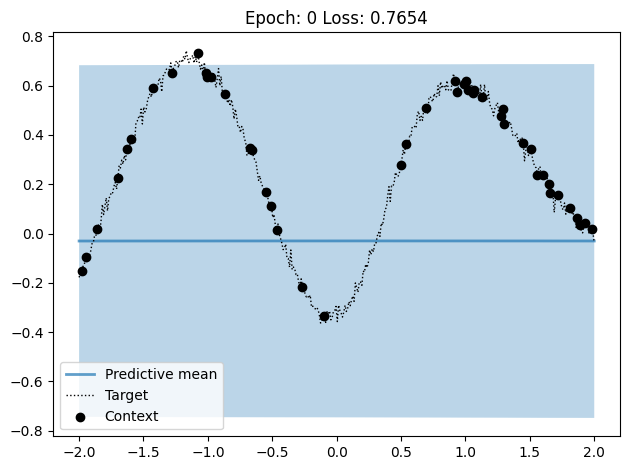

In [2]:
# Randomized kernel parameters
train_gen = GPDataGenerator(max_n_context=50, randomize_kernel_params=True)
test_gen = GPDataGenerator(testing=True, max_n_context=50, batch_size=1, randomize_kernel_params=True)

attention = Attention(attention_type="multihead", embed_dim=128, scale=1.0)
model = ANPModel(x_dim=1, y_dim=1, hidden_dim=128, attention=attention, latent_encoder_layers=6, deterministic_encoder_layers=6, decoder_layers=4)
train_1d(model, epochs=1, train_gen=train_gen, test_gen=test_gen)

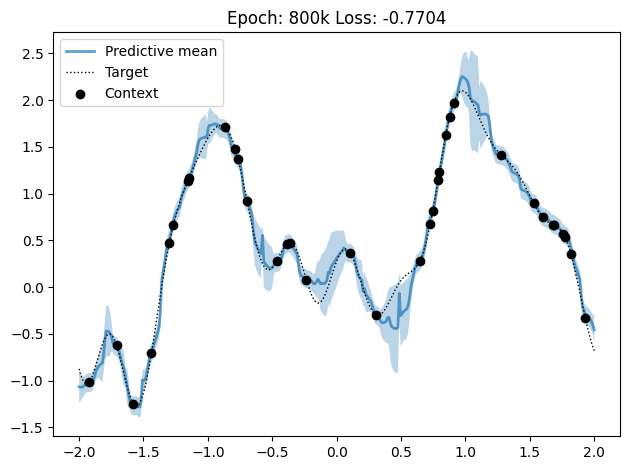

In [4]:
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel


gen_changing_kernel_params = GPDataGenerator(kernel=RBF(0.2), testing=True, batch_size=10, max_n_context=50)

checkpoint = torch.load("anp_model_fix_lr.pt") # 
model.load_state_dict(checkpoint["model_state_dict"])
model.to("cpu")
model.eval()
context_x, context_y, target_x, target_y = gen_changing_kernel_params.generate_batch().get_all()
pred_y, std, loss, _, _ = model(context_x, context_y, target_x, target_y)
plot_np_results(target_x.detach().numpy()[0], 
                target_y.detach().numpy()[0], 
                context_x.detach().numpy()[0], 
                context_y.detach().numpy()[0], 
                pred_y.detach().numpy()[0], 
                std.detach().numpy()[0], 
                title=f"Epoch: 800k Loss: {loss.item():.4f}")